In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d apollo2506/landuse-scene-classification
!unzip landuse-scene-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000365.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000366.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000367.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000368.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000369.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000371.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000372.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000374.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000376.png  
  inflating: images_train_test_val/train/mediumresidential/mediumresidential_000377.png  
  inflating: images_train_test_val/train/mediumre

In [3]:
ls images/

agricultural/     chaparral/         harbor/             parkinglot/         tenniscourt/
airplane/         denseresidential/  intersection/       river/
baseballdiamond/  forest/            mediumresidential/  runway/
beach/            freeway/           mobilehomepark/     sparseresidential/
buildings/        golfcourse/        overpass/           storagetanks/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

original_ds = '/content/drive/MyDrive/EDA/images/'
dataset=dir=aug_dir='/content/drive/MyDrive/EDA/aug_ds'
temporary_ds = '/content/temp'

Mounted at /content/drive


In [ ]:
!rm -rf /content/drive/MyDrive/EDA/aug_ds/
!rm -rf /content/temp

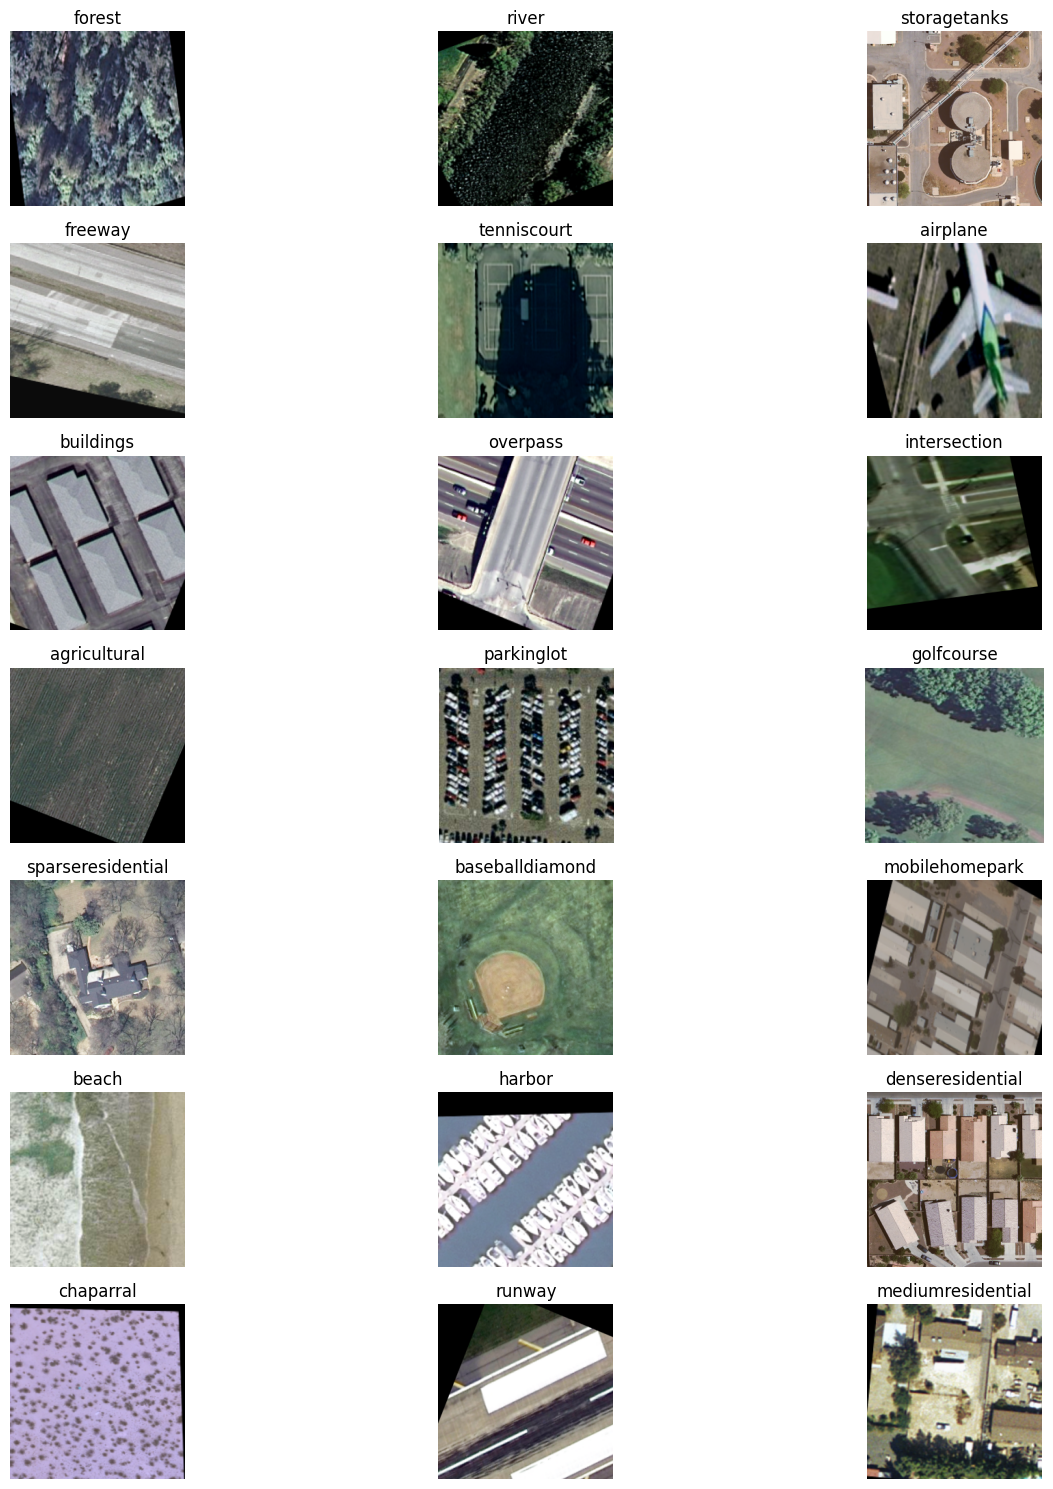

In [15]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to the directory containing images
image_dir = "images"

# Get the list of directories inside the "images" directory
directories = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]

# Number of columns in the grid
num_columns = 3

# Calculate the number of rows required
num_directories = len(directories)
num_rows = -(-num_directories // num_columns)  # Equivalent to ceil(num_directories / num_columns)

# Create a subplot grid
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 15))

# Flatten the subplot grid to simplify indexing
axs = axs.flatten()

# Iterate over each directory
for i, directory in enumerate(directories):
    # Construct the full path to the directory
    full_dir_path = os.path.join(image_dir, directory)
    # Get list of image files in the directory
    image_files = [f for f in os.listdir(full_dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]
    # Check if there are any image files
    if image_files:
        # Load and display the first image from the directory
        image_path = os.path.join(full_dir_path, image_files[0])
        image = Image.open(image_path)
        # Calculate subplot index
        row_index = i // num_columns
        col_index = i % num_columns
        # Display the image in the corresponding subplot
        axs[i].imshow(image)
        axs[i].set_title(directory)  # Set the title as the directory name
        axs[i].axis('off')
    else:
        print(f"No image found in {directory}")

# Hide empty subplots
for k in range(len(directories), num_rows * num_columns):
    axs[k].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# verify classes are balanced
def count_images(directory):
    image_count = 0
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        if os.path.isfile(img_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_count += 1
    return image_count

# Loop through each class (subdirectory) in the dataset directory
for subdir in os.listdir(original_ds):
    class_dir = os.path.join(original_ds, subdir)

    # Check if it's a directory
    if os.path.isdir(class_dir):
        # Count the number of images in this class directory
        image_count = count_images(class_dir)
        print(f"Class {subdir}: {image_count} images")
    else:
        print(f"{subdir} is not a directory.")

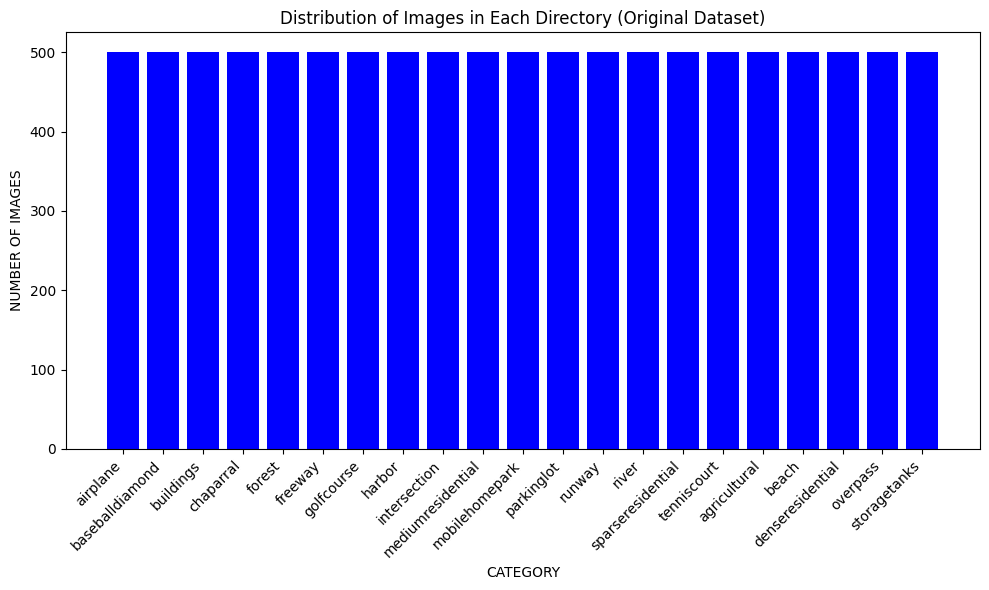

In [ ]:
import matplotlib.pyplot as plt

Categories = []
Category_image_count = []

# Iterate through each subdirectory
for subdir in os.listdir(original_ds):
    subdir_path = os.path.join(original_ds, subdir)
    if os.path.isdir(subdir_path):
        count_images = len([file for file in os.listdir(subdir_path)
                          if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
        Categories.append(subdir)
        Category_image_count.append(count_images)

# Create a bar chart to visualize the distribution of images
plt.figure(figsize=(10, 6))
plt.bar(Categories, Category_image_count, color='blue')
plt.xlabel('CATEGORY')
plt.ylabel('NUMBER OF IMAGES')
plt.title('Distribution of Images in Each Directory (Original Dataset)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#copy small Dataset (30 img) from original ds to smalldataset





In [ ]:
import os
import shutil
!rm -rf aug_dir

def copy_images(src, dest, max_count_per_folder):
    total_count = 0
    for dirpath, dirnames, filenames in os.walk(src):
        for dir in dirnames:
            src_dir_path = os.path.join(dirpath, dir)
            dest_dir_path = os.path.join(dest, os.path.relpath(src_dir_path, src))
            if not os.path.exists(dest_dir_path):
                os.makedirs(dest_dir_path)
            count = 0
            for file in os.listdir(src_dir_path):
                src_file_path = os.path.join(src_dir_path, file)
                dest_file_path = os.path.join(dest_dir_path, file)
                if os.path.isfile(src_file_path):
                    shutil.copy2(src_file_path, dest_file_path)
                    count += 1
                    total_count += 1
                    if count >= max_count_per_folder:
                        break
                if total_count >= max_count_per_folder * len(os.listdir(src)):
                    return total_count
    return total_count

train_count = copy_images(original_ds, aug_dir, 30)
print(f"Total {train_count} images copied from original_ds to smalldataset.")

Total 630 images copied from original_ds to smalldataset.


In [ ]:
# temporarily holds images until all 6 augmentations are done
import shutil

if not os.path.exists(temporary_ds):
            os.makedirs(temporary_ds, exist_ok=True)

for sub_dir in os.listdir(aug_dir):
    sub_dir_path = os.path.join(aug_dir, sub_dir)
    temp_dir_path = os.path.join(temporary_ds, sub_dir)

    if os.path.isdir(sub_dir_path):
        if not os.path.exists(temp_dir_path):
            os.makedirs(temp_dir_path, exist_ok=True)

        for img in os.listdir(sub_dir_path):
            img_path = os.path.join(sub_dir_path, img)
            temp_img_path = os.path.join(temp_dir_path, img)

            if not os.path.exists(temp_img_path):
                shutil.copy2(img_path, temp_img_path)
                # print(f'Copied image {img_path} to {aug_img_path}')
            else:
                # print(f'image already present at {aug_img_path}')
                pass

## pixel Distribution

In [ ]:
import os
import plotly.express as px

image_sizes = []

for subdir in os.listdir(dir):
    subdir_path = os.path.join(dir, subdir)
    if os.path.isdir(subdir_path):
        for img in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path,img)
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                size = os.path.getsize(img_path)
                image_sizes.append(size / 1_000_000)  # Convert bytes to megabytes

# Create a histogram to visualize the distribution of image sizes
fig = px.histogram(x=image_sizes, nbins=50, title="Distribution of Image Sizes")
fig.update_layout(
    title='Distribution of Image Sizes',
    xaxis_title='Image Size (MB)',
    yaxis_title='Frequency',
    showlegend=False,
    bargap=0.1,
    bargroupgap=0.1
)
fig.show()

In [ ]:
# Normalise pixels
import numpy as np
from PIL import Image

def normalize_image(input_path):
    original = Image.open(input_path)
    img_array = np.array(original)
    normalized_image = img_array / 255.0   # Normalize pixels
    normalized_image = Image.fromarray((normalized_image * 255).astype(np.uint8))
    normalized_image.save(input_path)

for subdir in os.listdir(dir):
    subdir_path = os.path.join(dir, subdir)
    if os.path.isdir(subdir_path):
        for img in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, img)
            normalize_image(img_path)

In [ ]:
import os
import plotly.express as px

image_sizes = []

for subdir in os.listdir(dir):
    subdir_path = os.path.join(dir, subdir)
    if os.path.isdir(subdir_path):
        for img in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path,img)
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                size = os.path.getsize(img_path)
                image_sizes.append(size / 1_000_000)  # Convert bytes to megabytes

# Create a histogram to visualize the distribution of image sizes
fig = px.histogram(x=image_sizes, nbins=50, title="Distribution of Image Sizes")
fig.update_layout(
    title='Distribution of Image Sizes',
    xaxis_title='Image Size (MB)',
    yaxis_title='Frequency',
    showlegend=False,
    bargap=0.1,
    bargroupgap=0.1
)
fig.show()

#from Tensor flow keras official (image agumentation)


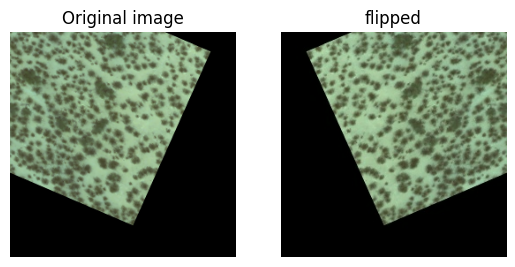

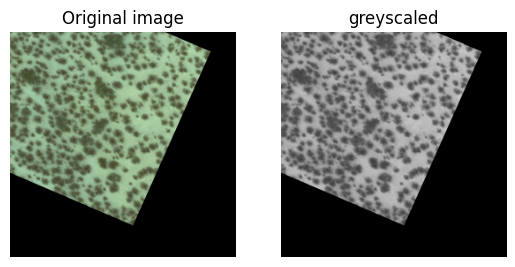

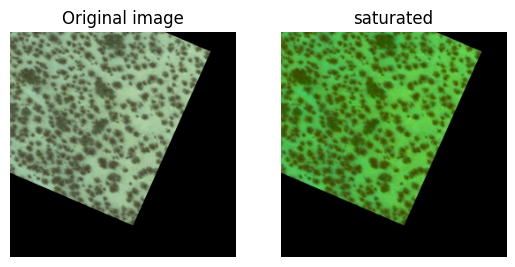

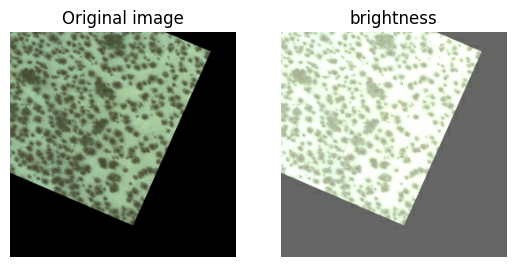

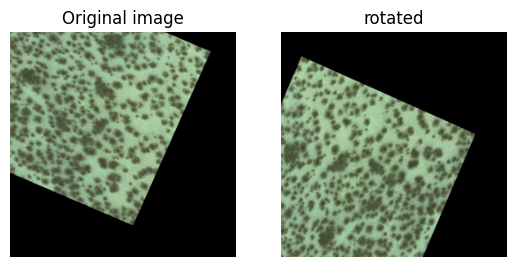

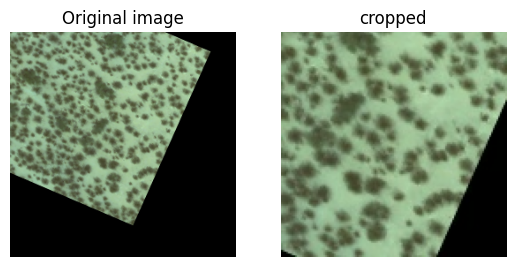

In [ ]:
import os
import tensorflow as tf
import numpy

def flip_images(original_img_path, aug_img_path):
    if not os.path.exists(aug_img_path):
        img_data = tf.io.read_file(original_img_path)
        img_tensor = tf.image.decode_image(img_data, channels=3)
        flipped_img = tf.image.flip_left_right(img_tensor)
        flipped_img_data = tf.image.encode_jpeg(flipped_img)
        tf.io.write_file(aug_img_path, flipped_img_data)

def greyscale_images(original_img_path, aug_img_path):
    if not os.path.exists(aug_img_path):
        img_data = tf.io.read_file(original_img_path)
        img_tensor = tf.image.decode_image(img_data, channels=3)
        greyscaled_image = tf.image.rgb_to_grayscale(img_tensor)
        greyscaled_image_data = tf.image.encode_jpeg(greyscaled_image)
        tf.io.write_file(aug_img_path, greyscaled_image_data)

def saturate_images(original_img_path, aug_img_path):
    if not os.path.exists(aug_img_path):
        img_data = tf.io.read_file(original_img_path)
        img_tensor = tf.image.decode_image(img_data, channels=3)
        saturated = tf.image.adjust_saturation(img_tensor, 3)
        saturated_image_data = tf.image.encode_jpeg(saturated)
        tf.io.write_file(aug_img_path, saturated_image_data)

def adjust_brightness(original_img_path, aug_img_path):
    if not os.path.exists(aug_img_path):
        img_data = tf.io.read_file(original_img_path)
        img_tensor = tf.image.decode_image(img_data, channels=3)
        bright = tf.image.adjust_brightness(img_tensor, 0.4)
        bright_image_data = tf.image.encode_jpeg(bright)
        tf.io.write_file(aug_img_path, bright_image_data)

def rotate_images(original_img_path, aug_img_path):
    if not os.path.exists(aug_img_path):
        img_data = tf.io.read_file(original_img_path)
        img_tensor = tf.image.decode_image(img_data, channels=3)
        rotated = tf.image.rot90(img_tensor)
        rotated_image_data = tf.image.encode_jpeg(rotated)
        tf.io.write_file(aug_img_path, rotated_image_data)

def crop_images(original_img_path, aug_img_path):
    if not os.path.exists(aug_img_path):
        img_data = tf.io.read_file(original_img_path)
        img_tensor = tf.image.decode_image(img_data, channels=3)
        cropped = tf.image.central_crop(img_tensor, central_fraction=0.5)
        cropped_image_data = tf.image.encode_jpeg(cropped)
        tf.io.write_file(aug_img_path, cropped_image_data)

def visualize(original_img_path, aug_img_path,prefix):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title('Original image')
    original_img = tf.io.read_file(original_img_path)
    original_img = tf.image.decode_jpeg(original_img, channels=3)
    plt.imshow(original_img.numpy().astype("uint8"))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f'{prefix}')
    aug_img = tf.io.read_file(aug_img_path)
    aug_img = tf.image.decode_jpeg(aug_img, channels=3)
    plt.imshow(aug_img.numpy().astype("uint8"))
    plt.axis('off')

    plt.show()



# Loop through directories and apply augmentations
def apply_augmentations_and_save(input_dir, output_dir, operation_func, prefix):
    count = 1
    visual=0
    for sub_dir in os.listdir(input_dir):
        sub_dir_path = os.path.join(input_dir, sub_dir)
        output_sub_dir_path = os.path.join(output_dir, sub_dir)
        os.makedirs(output_sub_dir_path, exist_ok=True)

        if visual==0:
          for image_name in os.listdir(sub_dir_path):
            original_img_path = os.path.join(sub_dir_path, image_name)
            aug_img_path = os.path.join(output_sub_dir_path, prefix + '_' + image_name)
            operation_func(original_img_path, aug_img_path)
            visualize(original_img_path, aug_img_path,prefix)
            visual = 1
            break

        for image_name in os.listdir(sub_dir_path):
            original_img_path = os.path.join(sub_dir_path, image_name)
            aug_img_path = os.path.join(output_sub_dir_path, prefix + '_' + image_name)

            operation_func(original_img_path, aug_img_path)

        # print(count, str(sub_dir), f": applied {operation_func.__name__}")
        count += 1
    visual = 0

# Define input and output directories
temporary_ds = temporary_ds
augmented_ds = dir

# Apply flipping
apply_augmentations_and_save(temporary_ds, augmented_ds, flip_images, 'flipped')

# Apply greyscaling
apply_augmentations_and_save(temporary_ds, augmented_ds, greyscale_images, 'greyscaled')

# Apply saturation adjustment
apply_augmentations_and_save(temporary_ds, augmented_ds, saturate_images, 'saturated')

# Apply brightness adjustment
apply_augmentations_and_save(temporary_ds, augmented_ds, adjust_brightness, 'brightness')

# Apply rotation
apply_augmentations_and_save(temporary_ds, augmented_ds, rotate_images, 'rotated')

# Apply cropping
apply_augmentations_and_save(temporary_ds, augmented_ds, crop_images, 'cropped')


**IMAGE COUNT**

In [ ]:
def count_images(directory):
    image_count = 0
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        if os.path.isfile(img_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_count += 1
    return image_count

for subdir in os.listdir(dir):
    path = os.path.join(dir, subdir)
    if os.path.isdir(path):
        image_count = count_images(path)
        print(f"Images in {subdir}: {image_count}")
    else:
        print(f"{subdir} is not a directory.")

Images in airplane: 210
Images in baseballdiamond: 210
Images in buildings: 210
Images in chaparral: 210
Images in forest: 210
Images in freeway: 210
Images in golfcourse: 210
Images in harbor: 210
Images in intersection: 210
Images in mediumresidential: 210
Images in mobilehomepark: 210
Images in parkinglot: 210
Images in runway: 210
Images in river: 210
Images in sparseresidential: 210
Images in tenniscourt: 210
Images in agricultural: 210
Images in beach: 210
Images in denseresidential: 210
Images in overpass: 210
Images in storagetanks: 210


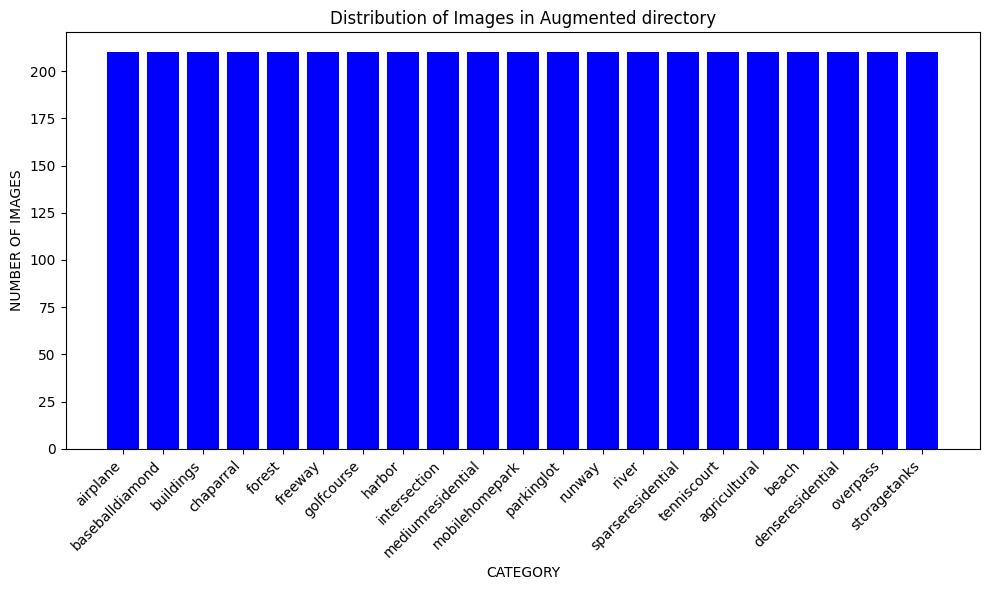

In [ ]:
import matplotlib.pyplot as plt

Categories = []
Category_image_count = []

# Iterate through each subdirectory
for subdir in os.listdir(dir):
    subdir_path = os.path.join(dir, subdir)
    if os.path.isdir(subdir_path):
        count_images = len([file for file in os.listdir(subdir_path)
                          if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
        Categories.append(subdir)
        Category_image_count.append(count_images)

# Create a bar chart to visualize the distribution of images
plt.figure(figsize=(10, 6))
plt.bar(Categories, Category_image_count, color='blue')
plt.xlabel('CATEGORY')
plt.ylabel('NUMBER OF IMAGES')
plt.title('Distribution of Images in Augmented directory')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
!rm -rf /content/temp

## Resized all images (254 x 254)

In [ ]:
from PIL import Image

def resize_image(input_path):
    if input_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        original = Image.open(input_path)
        new = original.resize((254, 254))
        new.save(input_path)
        print(f'resized image at {input_path}')

for subdir in os.listdir(dir):
    dest_dir = os.path.join(dir, subdir)
    if os.path.isdir(dest_dir):
        for img in os.listdir(dest_dir):
          img_path = os.path.join(dest_dir, img)
          resize_image(img_path)

resized image at /content/drive/MyDrive/EDA/aug_ds/airplane/airplane_000025.png
resized image at /content/drive/MyDrive/EDA/aug_ds/airplane/airplane_000047.png
resized image at /content/drive/MyDrive/EDA/aug_ds/airplane/airplane_000017.png
resized image at /content/drive/MyDrive/EDA/aug_ds/airplane/airplane_000045.png
resized image at /content/drive/MyDrive/EDA/aug_ds/airplane/airplane_000048.png
resized image at /content/drive/MyDrive/EDA/aug_ds/airplane/airplane_000031.png
resized image at /content/drive/MyDrive/EDA/aug_ds/airplane/airplane_000004.png
resized image at /content/drive/MyDrive/EDA/aug_ds/airplane/airplane_000029.png
resized image at /content/drive/MyDrive/EDA/aug_ds/airplane/airplane_000026.png
resized image at /content/drive/MyDrive/EDA/aug_ds/airplane/airplane_000007.png
resized image at /content/drive/MyDrive/EDA/aug_ds/airplane/airplane_000033.png
resized image at /content/drive/MyDrive/EDA/aug_ds/airplane/airplane_000021.png
resized image at /content/drive/MyDrive/

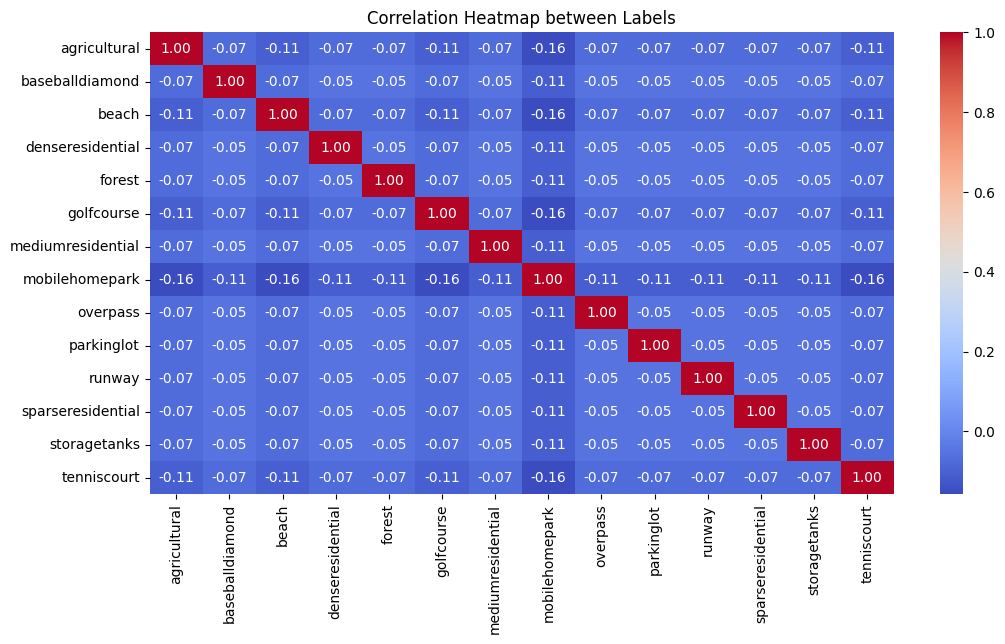

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class_names = []
for subdir in os.listdir(dir):
  class_names.append(subdir)

labels = np.random.choice(class_names,len(class_names))
df = pd.get_dummies(labels, columns=class_names)
correlation_matrix = df.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Labels')
plt.show()


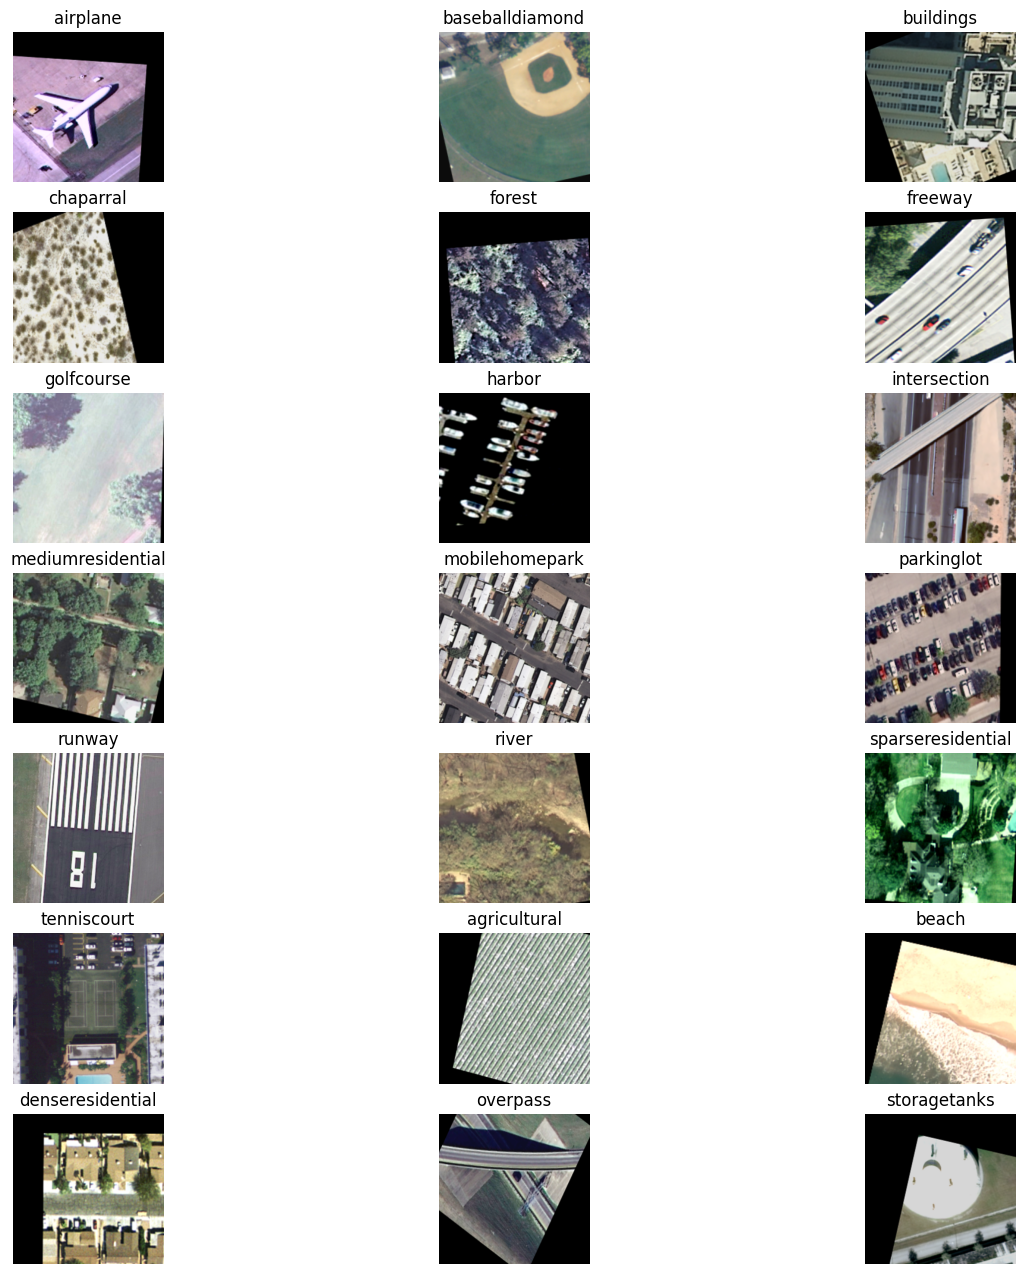

In [ ]:
import cv2
import matplotlib.pyplot as plt

class_names = os.listdir(dir)
num_classes = len(class_names)
num_rows = (num_classes // 3) + (1 if num_classes % 3 != 0 else 0)
num_cols = min(num_classes, 3)

plt.figure(figsize=(16, 16))  # Adjust the figure size to make the subplots bigger

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(dir, class_name)
    sample_image_files = os.listdir(class_dir)
    sample_image_path = os.path.join(class_dir, sample_image_files[0])
    sample_image = cv2.imread(sample_image_path)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(sample_image)
    plt.title(class_name)
    plt.axis('off')
plt.subplots_adjust(wspace=0.1)  #
plt.show()